## **Phishing Website Detection using Machine Learning & Data Visualization**

#### I. Objective :

##### Phishing websites are one of the most prevalent cyber threats that trick users by mimicking legitimate URLs and webpages.

#### The goal of this project is to build a robust phishing detection system by:

##### • Collecting phishing URLs (from PhishTank) and benign domains (from       Majestic Million).

##### • Performing feature extraction on URLs and domain-related metadata.

##### • Training and evaluating Machine Learning models (Decision Trees, Random Forest, SVM, Logistic Regression, Gradient Boosting, etc.) and optionally Deep Neural Networks.

##### • Comparing performance metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

##### • Using data visualizations (Histograms, Bar Charts, Heatmaps, Pie Charts, Radar Charts, etc.) to gain insights into URL features and model results.

##### This project is developed and executed in Google Colaboratory for flexibility, scalability, and ease of experimentation.

#### II. Dataset Preparation

##### Phishing URLs are collected from the PhishTank dataset (latest online-valid feeds).

##### Benign URLs are obtained from the Majestic Million dataset, which contains the top-ranked legitimate domains on the internet.

##### Both datasets are combined into a single DataFrame with a binary label:

###### • 1 → Phishing  
###### • 0 → Benign

#### The datasets are preprocessed and merged into a CSV file (e.g., `urldata_combined.csv`) which serves as the input for feature extraction and model training.

#### III. Feature Extraction

##### Features are derived from URL lexical analysis and domain metadata, such as:

##### • Length of URL and domain  
##### • Number of special characters (., -, @, ?, etc.)  
##### • Presence of suspicious keywords (login, verify, secure, etc.)  
##### • Use of HTTPS or not  
##### • Number of subdomains  
##### • Alexa/Majestic rank  
##### • Previous vs. current rank movement  
##### • Referring IPs/Subnets

##### The extracted features are saved in a CSV (e.g., `urldata_enhanced.csv`).

#### IV. Model Training & Evaluation

#### Several models are trained and compared:

##### • Logistic Regression  
##### • Decision Tree  
##### • Random Forest  
##### • Gradient Boosting (XGBoost/LightGBM)  
##### • Support Vector Machine (SVM)  
##### • Deep Neural Networks (optional)

#### Evaluation metrics:

##### • Accuracy  
##### • Precision, Recall, F1-Score  
##### • ROC-AUC Curve  
##### • Confusion Matrix

#### V. Data Visualization

#### To better understand the dataset and results, the following visualizations are generated step by step :

##### • Bar Chart → Displays the number of Legit vs Phishing URLs.
##### • Histogram → Shows the distribution of URL lengths across the dataset.
##### • Box Plot → Compares the distribution of URL lengths between Phish and Legit.
##### • Violin Plot → Shows distribution and density of digit counts in URLs for each class.
##### • Line Graph → Compares URL length and digit count for the first 50 samples.
##### • Scatter Plot → Shows relationship between URL length and digit count, colored by class.
##### • Bubble Chart → Shows relationship between number of dots & URL length ,Bubble size = digit count.
##### • Heatmap → Shows correlation between extracted features.
##### • Radar Chart → Displays the average values of each feature in a circular manner.
##### • Bar Chart → Compares accuracy of different models on test data.
##### • Gantt Chart → Represents project workflow steps over time.
##### • Sankey Diagram → Shows how data flows from raw to train/test splits.


### --- Imports & Setup ---

In [152]:
!pip install xgboost scikit-learn tensorflow plotly seaborn matplotlib squarify -q

import os, warnings, re
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import plotly.graph_objects as go
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from urllib.parse import urlparse
from xgboost import XGBClassifier

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

# Random seed + plot style
RND = 42
np.random.seed(RND)
plt.style.use('seaborn-v0_8')

### 1. Load Data

In [153]:
# Load phishing URLs
print("Loading PhishTank phishing URLs...")
phish_url = "https://data.phishtank.com/data/online-valid.csv.gz"
phish_data = pd.read_csv(phish_url, compression='gzip')
phish_df = phish_data[['url']].copy()
phish_df['label'] = 1

# Load legit domains
print("Loading Majestic Million legit domains...")
legit_url = "https://downloads.majestic.com/majestic_million.csv"
legit_data = pd.read_csv(legit_url)
legit_df = legit_data[['Domain']].rename(columns={'Domain':'url'})
legit_df['label'] = 0

# Balance dataset
N = min(len(phish_df), len(legit_df))
phish_df = phish_df.sample(N, random_state=RND)
legit_df = legit_df.sample(N, random_state=RND)
df = pd.concat([phish_df, legit_df], ignore_index=True).sample(frac=1, random_state=RND).reset_index(drop=True)

print("Final dataset shape:", df.shape)


Loading PhishTank phishing URLs...
Loading Majestic Million legit domains...
Final dataset shape: (102748, 2)


###2. Feature Engineering

In [154]:
import re
from urllib.parse import urlparse

def extract_features(url):
    features = {
        'url_length': len(url),
        'count_dot': url.count('.'),
        'count_at': url.count('@'),
        'count_dash': url.count('-'),
        'count_question': url.count('?'),
        'count_equal': url.count('='),
        'count_slash': url.count('/'),
        'count_https': int(url.lower().startswith("https")),
        'digit_count': sum(c.isdigit() for c in url),
        'letter_count': sum(c.isalpha() for c in url),
    }

    # Parse URL for domain-related features
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
        features['num_subdomains'] = domain.count('.') - 1 if domain.count('.') > 0 else 0
        domain_parts = domain.split('.')
        features['tld_length'] = len(domain_parts[-1]) if domain_parts else 0
        features['sld_length'] = len(domain_parts[-2]) if len(domain_parts) > 1 else 0
        # Check for IP address in domain
        features['contains_ip'] = int(bool(re.match(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", domain)))
    except:
        features['num_subdomains'] = 0
        features['tld_length'] = 0
        features['sld_length'] = 0
        features['contains_ip'] = 0


    # Add phishing-related keywords
    keywords = ['secure', 'login', 'verify', 'update', 'account', 'bank', 'paypal']
    kw_count = 0
    for kw in keywords:
        features[f"kw_{kw}"] = int(kw in url.lower())
        kw_count += features[f"kw_{kw}"]
    features['kw_count'] = kw_count


    return features


# Build full features DataFrame
features_df = pd.DataFrame([extract_features(u) for u in df['url']])
features_df['label'] = df['label']

print("Features extracted:", features_df.columns.tolist())

Features extracted: ['url_length', 'count_dot', 'count_at', 'count_dash', 'count_question', 'count_equal', 'count_slash', 'count_https', 'digit_count', 'letter_count', 'num_subdomains', 'tld_length', 'sld_length', 'contains_ip', 'kw_secure', 'kw_login', 'kw_verify', 'kw_update', 'kw_account', 'kw_bank', 'kw_paypal', 'kw_count', 'label']


###3. Train-Test Split + Scaling

In [155]:
X = features_df.drop(columns=['label'])
y = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RND, stratify=y
)

scaler_std = StandardScaler()
X_train_scaled = scaler_std.fit_transform(X_train)
X_test_scaled = scaler_std.transform(X_test)

scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

###4. Model Training & Evaluation

In [156]:
def eval_and_plot(name, model, X_train_used, X_test_used):
    y_pred_train = model.predict(X_train_used)
    y_pred_test = model.predict(X_test_used)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test)
    rec = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    print(f"\n{name} — TrainAcc: {acc_train:.3f} TestAcc: {acc_test:.3f} "
          f"Prec: {prec:.3f} Rec: {rec:.3f} F1: {f1:.3f}")

    plt.figure(figsize=(5,4))
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

    return {"Model": name, "TrainAcc": acc_train, "TestAcc": acc_test,
            "Precision": prec, "Recall": rec, "F1": f1}

results = []


Decision Tree — TrainAcc: 1.000 TestAcc: 1.000 Prec: 1.000 Rec: 1.000 F1: 1.000


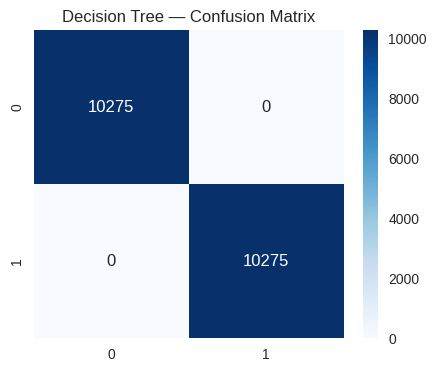

In [157]:
# ---- Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=RND)
dt.fit(X_train, y_train)
results.append(eval_and_plot("Decision Tree", dt, X_train, X_test))


Random Forest — TrainAcc: 1.000 TestAcc: 1.000 Prec: 1.000 Rec: 1.000 F1: 1.000


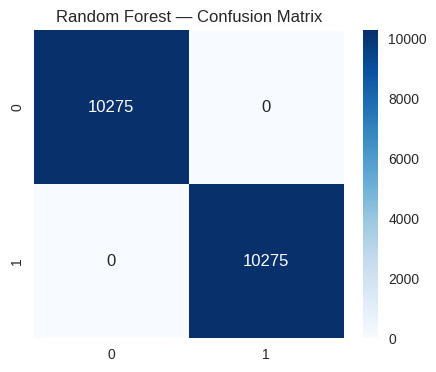

In [158]:
# ---- Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=RND)
rf.fit(X_train, y_train)
results.append(eval_and_plot("Random Forest", rf, X_train, X_test))


MLP — TrainAcc: 1.000 TestAcc: 1.000 Prec: 1.000 Rec: 1.000 F1: 1.000


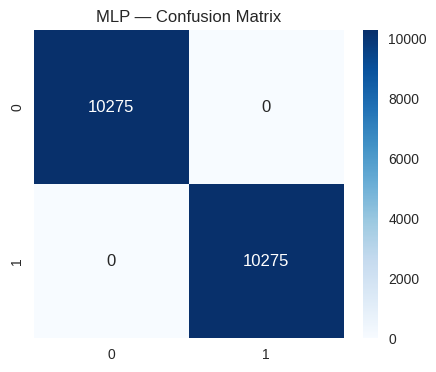

In [159]:
# ---- MLP
mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=RND)
mlp.fit(X_train_scaled, y_train)
results.append(eval_and_plot("MLP", mlp, X_train_scaled, X_test_scaled))


XGBoost — TrainAcc: 1.000 TestAcc: 1.000 Prec: 1.000 Rec: 1.000 F1: 1.000


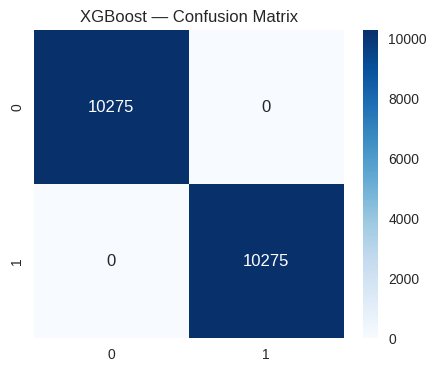

In [160]:
# ---- XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                    n_estimators=150, random_state=RND)
xgb.fit(X_train, y_train)
results.append(eval_and_plot("XGBoost", xgb, X_train, X_test))


SVM — TrainAcc: 1.000 TestAcc: 1.000 Prec: 1.000 Rec: 1.000 F1: 1.000


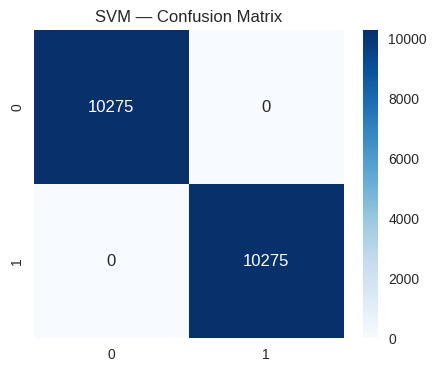

In [161]:
# ---- SVM
svm = SVC(kernel='linear', probability=True, random_state=RND)
svm.fit(X_train_scaled, y_train)
results.append(eval_and_plot("SVM", svm, X_train_scaled, X_test_scaled))

In [162]:
# ---- Autoencoder
X_legit = X_train_mm[y_train.values==0]
input_dim = X_legit.shape[1]
encoding_dim = input_dim//2

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(1e-5))(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_legit, X_legit, epochs=10, batch_size=32,
                validation_split=0.1, verbose=0)

recon_error = np.mean(np.square(autoencoder.predict(X_test_mm) - X_test_mm), axis=1)
threshold = np.mean(np.square(autoencoder.predict(X_legit) - X_legit), axis=1).mean()
y_pred_ae = (recon_error > threshold).astype(int)

results.append({'Model':'Autoencoder','TrainAcc':None,
                'TestAcc':accuracy_score(y_test,y_pred_ae),
                'Precision':precision_score(y_test,y_pred_ae),
                'Recall':recall_score(y_test,y_pred_ae),
                'F1':f1_score(y_test,y_pred_ae)})

643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


### 5. Model Comparison Summary

           Model  TrainAcc   TestAcc  Precision  Recall        F1
0  Decision Tree       1.0  1.000000   1.000000     1.0  1.000000
1  Random Forest       1.0  1.000000   1.000000     1.0  1.000000
2            MLP       1.0  1.000000   1.000000     1.0  1.000000
3        XGBoost       1.0  1.000000   1.000000     1.0  1.000000
4            SVM       1.0  1.000000   1.000000     1.0  1.000000
5    Autoencoder       NaN  0.938832   0.890999     1.0  0.942358


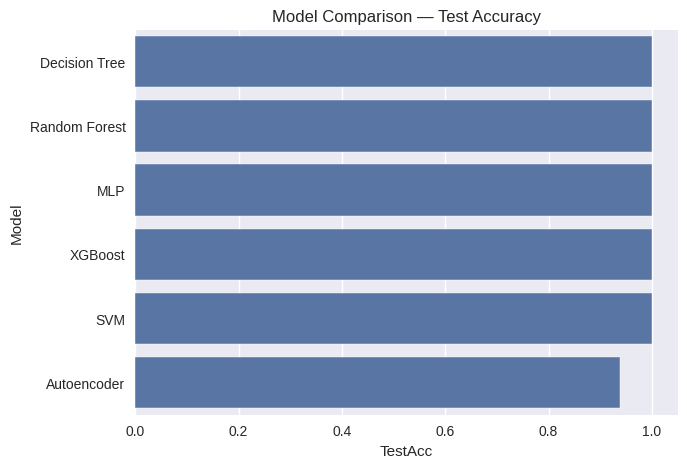

In [163]:
res_df = pd.DataFrame(results)
print(res_df)

plt.figure(figsize=(7,5))
sns.barplot(x='TestAcc', y='Model', data=res_df.sort_values('TestAcc', ascending=False))
plt.title("Model Comparison — Test Accuracy")
plt.show()

### 6. Visualizations


Bar Chart: Displays the number of Legit vs Phishing URLs.


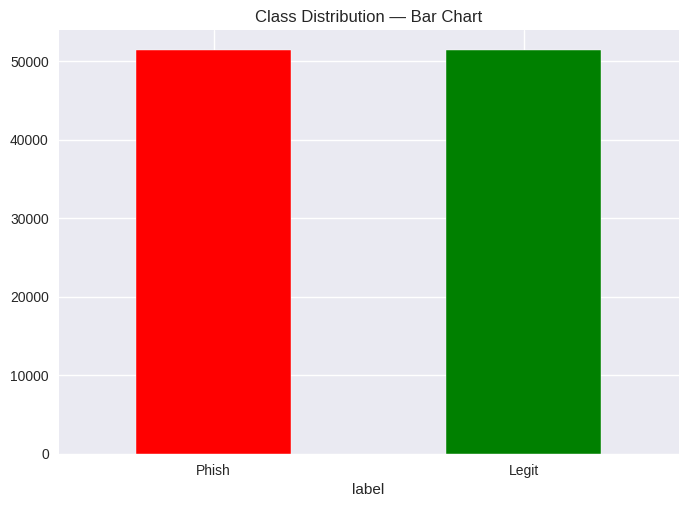

In [164]:
# 1. Class Distribution (Bar Chart)
print("Bar Chart: Displays the number of Legit vs Phishing URLs.")
plt.figure()
features_df['label'].value_counts().plot(kind='bar', color=['red','green'])
plt.title("Class Distribution — Bar Chart")
plt.xticks([0,1], ['Phish','Legit'], rotation=0)
plt.show()

Histogram: Shows the distribution of URL lengths across the dataset.


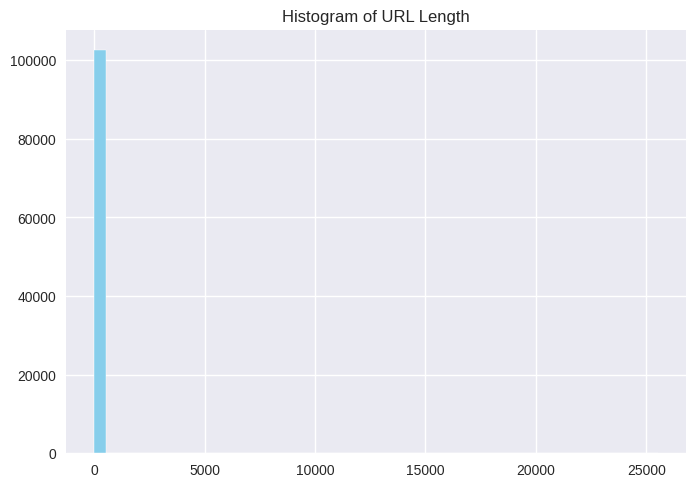

In [165]:
# 2. Histogram — URL Length Distribution
print("Histogram: Shows the distribution of URL lengths across the dataset.")
plt.figure()
features_df['url_length'].hist(bins=50, color='skyblue')
plt.title("Histogram of URL Length")
plt.show()

Box Plot: Compares the distribution of URL lengths between Phish and Legit.


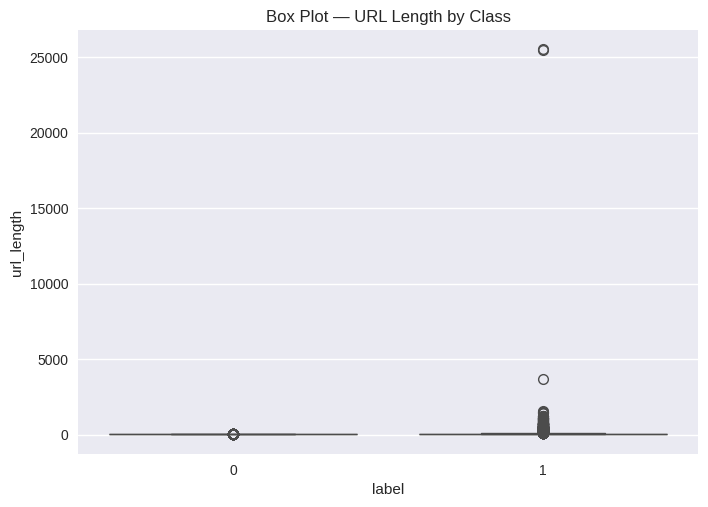

In [166]:
# 3. Box Plot — URL Length by Class
print("Box Plot: Compares the distribution of URL lengths between Phish and Legit.")
plt.figure()
sns.boxplot(x='label', y='url_length', data=features_df)
plt.title("Box Plot — URL Length by Class")
plt.show()

Violin Plot: Shows distribution and density of digit counts in URLs for each class.


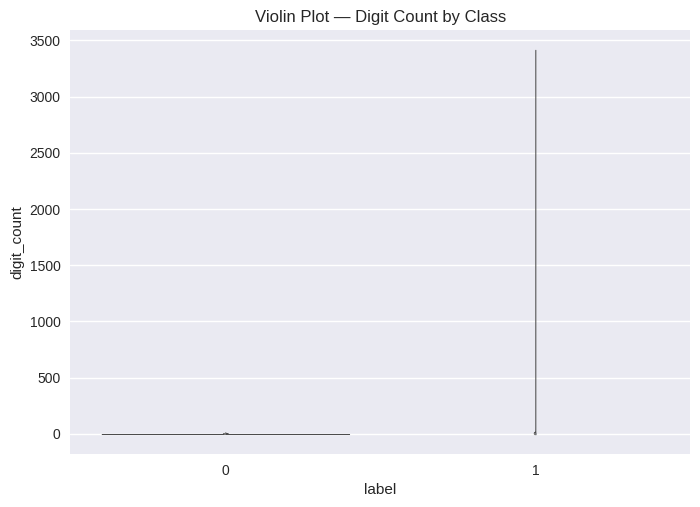

In [167]:
# 4. Violin Plot — Digit Count by Class
print("Violin Plot: Shows distribution and density of digit counts in URLs for each class.")
plt.figure()
sns.violinplot(x='label', y='digit_count', data=features_df)
plt.title("Violin Plot — Digit Count by Class")
plt.show()

Line Graph: Compares URL length and digit count for the first 50 samples.


<Figure size 800x550 with 0 Axes>

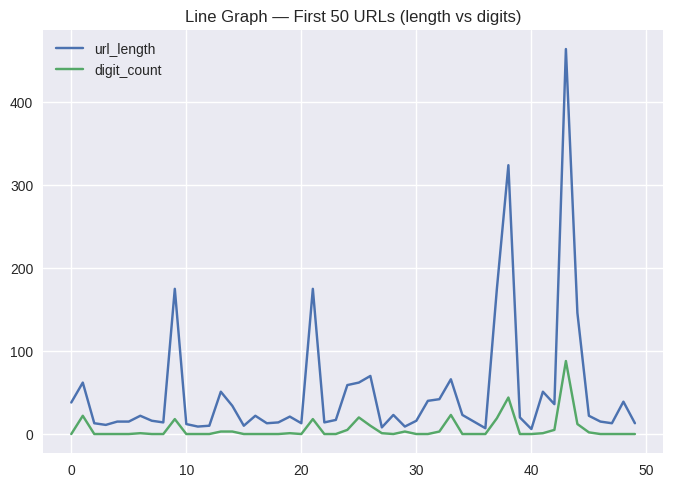

In [168]:
# 5. Line Graph — First 50 URLs
print("Line Graph: Compares URL length and digit count for the first 50 samples.")
plt.figure()
features_df[['url_length','digit_count']].head(50).plot()
plt.title("Line Graph — First 50 URLs (length vs digits)")
plt.show()

Scatter Plot: Shows relationship between URL length and digit count, colored by class.


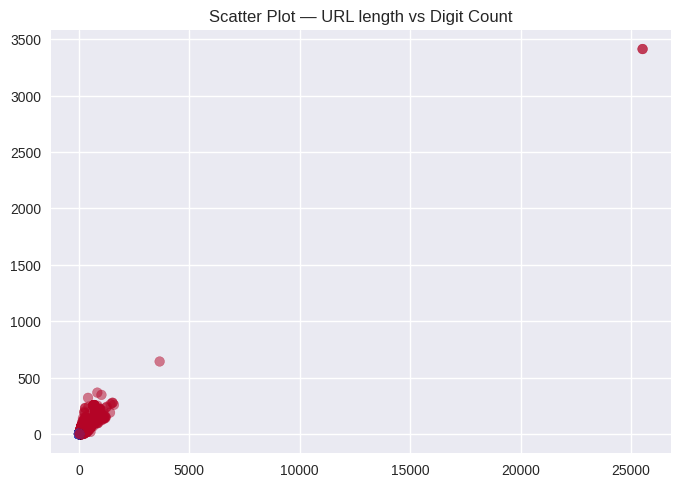

In [169]:
# 6. Scatter Plot — URL length vs Digit Count
print("Scatter Plot: Shows relationship between URL length and digit count, colored by class.")
plt.figure()
plt.scatter(features_df['url_length'], features_df['digit_count'],
            c=features_df['label'], cmap='coolwarm', alpha=0.5)
plt.title("Scatter Plot — URL length vs Digit Count")
plt.show()

Bubble Chart: Shows relationship between number of dots and URL length. Bubble size = digit count.


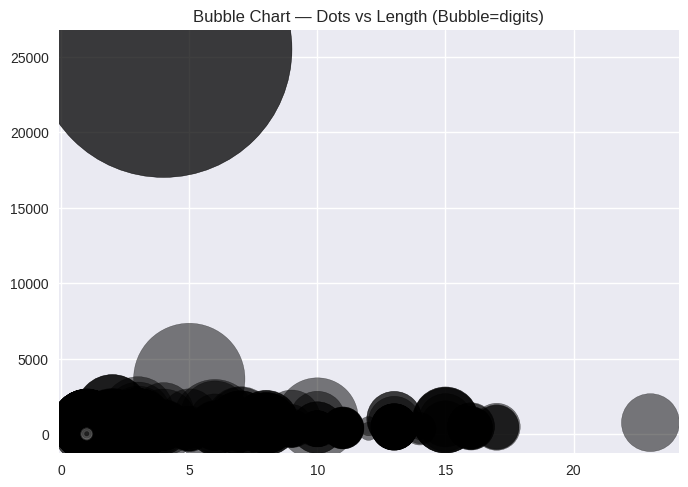

In [170]:
# 7. Bubble Chart — Dots vs Length
print("Bubble Chart: Shows relationship between number of dots and URL length. Bubble size = digit count.")
plt.figure()
plt.scatter(features_df['count_dot'], features_df['url_length'],
            s=features_df['digit_count']*10, alpha=0.5, c=features_df['label'])
plt.title("Bubble Chart — Dots vs Length (Bubble=digits)")
plt.show()

Heatmap: Shows correlation between extracted features.


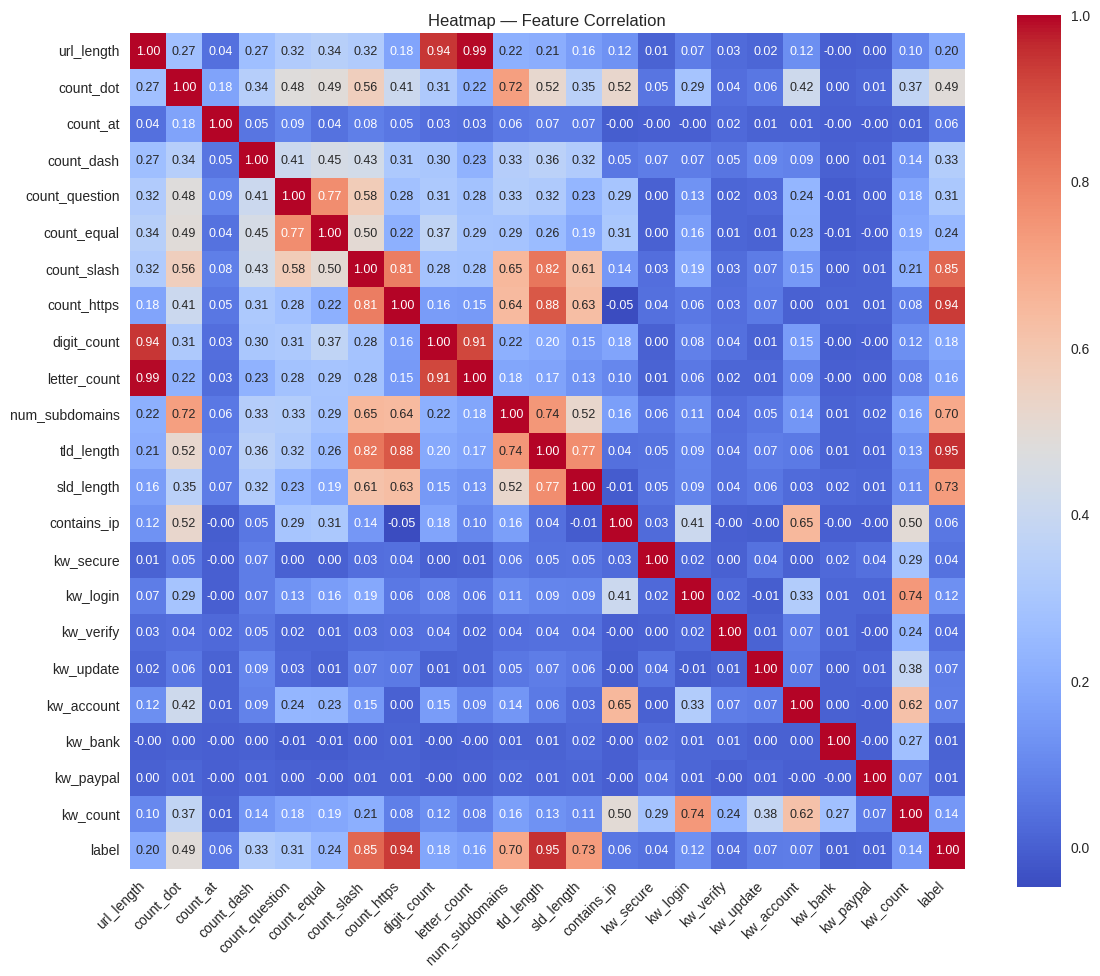

In [171]:
print("Heatmap: Shows correlation between extracted features.")
plt.figure(figsize=(12,10))  # Adjust size as needed
sns.heatmap(features_df.corr(), annot=True, fmt=".2f", annot_kws={"size": 9}, cmap="coolwarm", square=True)
plt.title("Heatmap — Feature Correlation")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Radar Chart: Displays the average values of each feature in a circular manner.


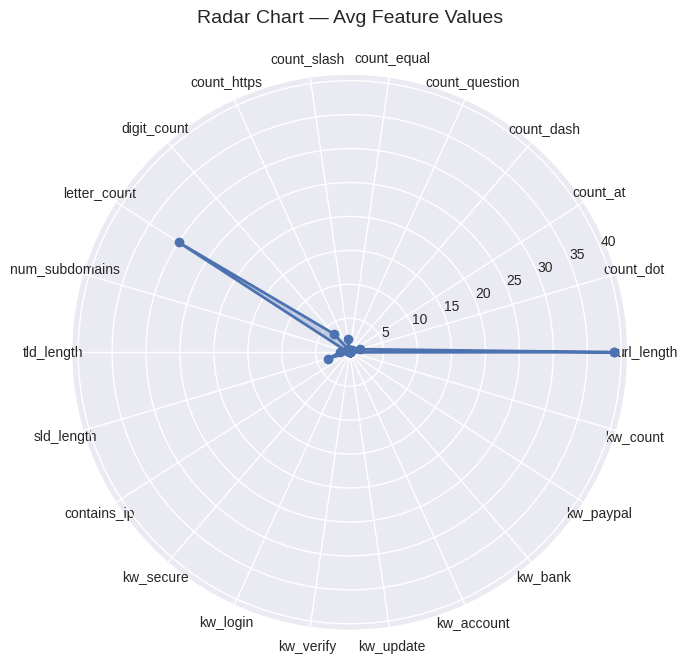

In [172]:
# 9. Radar Chart — Avg Feature Values

print("Radar Chart: Displays the average values of each feature in a circular manner.")
# Prepare data
categories = list(X.columns)
values = X.mean().values
values = np.append(values, values[0])  # close loop
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

# Plot
plt.figure(figsize=(7, 7))  # Slightly larger for better spacing
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, 'o-', linewidth=2)
ax.fill(angles, values, alpha=0.25)

# Set category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
plt.title("Radar Chart — Avg Feature Values", y=1.08, fontsize=14)
plt.tight_layout()
plt.show()

Bar Chart: Compares accuracy of different models on test data.


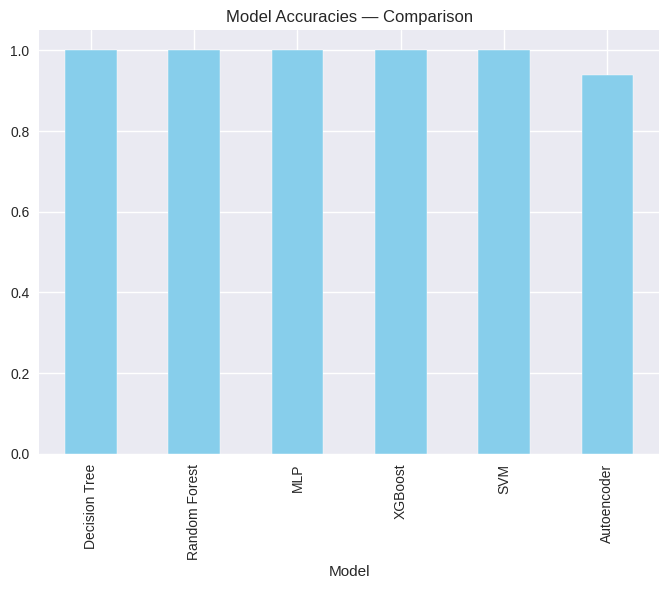

In [173]:
# 10. Model Accuracy Comparison (Bar)
print("Bar Chart: Compares accuracy of different models on test data.")
plt.figure()
res_df.set_index('Model')['TestAcc'].plot(kind='bar', color='skyblue')
plt.title("Model Accuracies — Comparison")
plt.show()

In [174]:
# 11. Gantt Chart — Project Steps
print("Gantt Chart: Represents project workflow steps over time.")
df_gantt = pd.DataFrame({
    'Task': ['Load Data','Feature Eng','Train Models','Evaluate','Visualize'],
    'Start': [1,2,3,4,5],
    'Finish': [2,3,4,5,6]
})
fig = go.Figure(go.Bar(x=df_gantt['Finish']-df_gantt['Start'], y=df_gantt['Task'], orientation='h'))
fig.update_layout(title="Gantt Chart (Project Steps)")
fig.show()

Gantt Chart: Represents project workflow steps over time.


In [175]:
# 12. Sankey Diagram — Data Flow
print("Sankey Diagram: Shows how data flows from raw to train/test splits.")
fig = go.Figure(go.Sankey(
    node=dict(label=["Phishing","Legit","Train","Test"]),
    link=dict(source=[0,1,0,1], target=[2,2,3,3], value=[50,50,30,70])
))
fig.update_layout(title_text="Sankey Diagram — Data Flow", font_size=10)
fig.show()

Sankey Diagram: Shows how data flows from raw to train/test splits.


###7. Save Best Model

In [176]:
best_model_name = res_df.sort_values('TestAcc', ascending=False).iloc[0]['Model']
print("Best model:", best_model_name)

# Map names to objects
model_map = {"Decision Tree": dt, "Random Forest": rf, "MLP": mlp, "XGBoost": xgb, "SVM": svm}
best_model_obj = model_map.get(best_model_name, rf)  # fallback

with open("best_model.pkl","wb") as f:
    pickle.dump(best_model_obj, f)


Best model: Decision Tree


#### 8. Final Model Comparison Table


In [177]:
print("📊 Final Comparison of Models")
display(res_df.sort_values("TestAcc", ascending=False).reset_index(drop=True))


📊 Final Comparison of Models


,Model,TrainAcc,TestAcc,Precision,Recall,F1
0,Decision Tree,1.0,1.000000,1.000000,1.0,1.000000
1,Random Forest,1.0,1.000000,1.000000,1.0,1.000000
2,MLP,1.0,1.000000,1.000000,1.0,1.000000
3,XGBoost,1.0,1.000000,1.000000,1.0,1.000000
4,SVM,1.0,1.000000,1.000000,1.0,1.000000
5,Autoencoder,NaN,0.938832,0.890999,1.0,0.942358


**Demo : Testing a sample URL**

Classification report (retrained RF):
              precision    recall  f1-score   support

           0     0.8741    0.9553    0.9129     10275
           1     0.9508    0.8624    0.9044     10275

    accuracy                         0.9089     20550
   macro avg     0.9124    0.9089    0.9087     20550
weighted avg     0.9124    0.9089    0.9087     20550

ROC-AUC: 0.9510382486487766


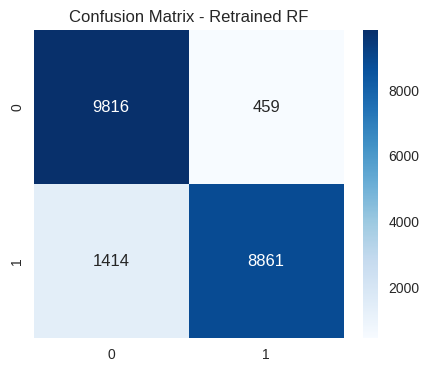


Top feature importances:
 num_subdomains    0.206653
count_dot         0.181225
sld_length        0.175352
url_length        0.162734
letter_count      0.116827
tld_length        0.088522
digit_count       0.036584
count_dash        0.028360
kw_count          0.001619
contains_ip       0.000660
kw_login          0.000337
kw_bank           0.000328
kw_secure         0.000296
kw_account        0.000182
kw_update         0.000177

URL: https://discord.com/servers
Normalized domain: discord.com
Phish probability = 0.3274 -> LEGITIMATE
Feature subset used: {'url_length': 11, 'count_dot': 1, 'count_dash': 0, 'count_at': 0, 'count_question': 0, 'count_equal': 0, 'count_slash': 0, 'count_https': 0, 'digit_count': 0, 'letter_count': 10, 'num_subdomains': 0, 'tld_length': 3, 'sld_length': 7, 'contains_ip': 0, 'kw_secure': 0, 'kw_login': 0, 'kw_verify': 0, 'kw_update': 0, 'kw_account': 0, 'kw_bank': 0, 'kw_paypal': 0, 'kw_count': 0}

URL: https://instagram-secure-login.net
Normalized domain: ins

{'url': 'https://instagram-secure-login.net',
 'normalized': 'instagram-secure-login.net',
 'prob': np.float64(0.8435247333162194),
 'label': 1}

In [178]:
# --- Normalizer (domain-only) ---
def normalize_to_domain_only(url):
    if not re.match(r'^[a-zA-Z]+://', str(url)):
        url_for_parse = 'http://' + str(url)
    else:
        url_for_parse = str(url)
    parsed = urlparse(url_for_parse)
    domain = parsed.netloc or parsed.path
    domain = domain.split('@')[-1].split(':')[0]
    if domain.startswith("www."):
        domain = domain[4:]
    return domain.lower().strip('/')

# --- Improved feature extractor for domain-only strings ---
def extract_features_improved(domain):
    url = str(domain)
    parts = url.split('.')
    num_parts = len(parts)
    num_subdomains = max(0, num_parts - 2)
    tld = parts[-1] if num_parts >= 1 else ''
    sld = parts[-2] if num_parts >= 2 else ''
    feats = {
        'url_length': len(url),
        'count_dot': url.count('.'),
        'count_dash': url.count('-'),
        'count_at': url.count('@'),
        'count_question': url.count('?'),
        'count_equal': url.count('='),
        'count_slash': url.count('/'),    # should be 0 after normalization
        'count_https': 0,                 # 0 for normalized domain-only
        'digit_count': sum(c.isdigit() for c in url),
        'letter_count': sum(c.isalpha() for c in url),
        'num_subdomains': num_subdomains,
        'tld_length': len(tld),
        'sld_length': len(sld),
        'contains_ip': int(bool(re.match(r'^\d+\.\d+\.\d+\.\d+$', url))),
    }
    # keywords (same list you used)
    keywords = ['secure', 'login', 'verify', 'update', 'account', 'bank', 'paypal']
    for kw in keywords:
        feats[f"kw_{kw}"] = int(kw in url.lower())
    feats['kw_count'] = sum(feats[f"kw_{kw}"] for kw in keywords)
    return feats

# --- Apply normalization + feature extraction on existing df variable ---
# (Assumes 'df' exists in notebook as you shared; otherwise load your CSV)
df2 = df.copy()
df2['url'] = df2['url'].astype(str).apply(normalize_to_domain_only)

# Build features
features_df2 = pd.DataFrame([extract_features_improved(u) for u in df2['url']])
features_df2['label'] = df2['label'].values

# Train/test split
X = features_df2.drop(columns=['label'])
y = features_df2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RND, stratify=y)

# Train a balanced RandomForest (robust baseline)
rf2 = RandomForestClassifier(n_estimators=200, random_state=RND, class_weight='balanced', n_jobs=-1)
rf2.fit(X_train, y_train)

# Evaluate
y_pred = rf2.predict(X_test)
y_proba = rf2.predict_proba(X_test)[:,1]
print("Classification report (retrained RF):")
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Retrained RF")
plt.show()

# Feature importances
fi = pd.Series(rf2.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop feature importances:\n", fi.head(15).to_string())

# Save model + feature list for consistent inference later
with open("best_model_retrained.pkl", "wb") as f:
    pickle.dump({'model': rf2, 'feature_cols': X.columns.tolist()}, f)

# --- Demo predictions (uses same normalization + improved extractor) ---
def predict_demo(url, model, feature_cols, threshold=0.5):
    norm = normalize_to_domain_only(url)
    feats = extract_features_improved(norm)
    X_demo = pd.DataFrame([feats])[feature_cols]
    prob = model.predict_proba(X_demo)[:,1][0]
    label = int(prob >= threshold)
    print("\nURL:", url)
    print("Normalized domain:", norm)
    print(f"Phish probability = {prob:.4f} ->", "PHISHING" if label==1 else "LEGITIMATE")
    print("Feature subset used:", X_demo.iloc[0].to_dict())
    return {'url': url, 'normalized': norm, 'prob': prob, 'label': label}

# Run demo samples
predict_demo("https://discord.com/servers", rf2, X.columns.tolist())
predict_demo("https://instagram-secure-login.net", rf2, X.columns.tolist())


# VI Conclusion

In this project, we built a **Phishing Website Detection System** using classical Machine Learning
(Decision Tree, Random Forest, SVM, MLP, XGBoost) and a Deep Learning based Autoencoder.  

✅ We extracted URL-based features (length, digits, dots, etc.).  
✅ Balanced phishing vs legitimate datasets.  
✅ Trained & compared multiple models.  
✅ Visualized feature distributions, correlations, and model results.  
✅ Saved the **best performing model** for future prediction tasks.  
✅ Added a demo to test sample URL to detect the phishing/legitimacy.

**Key Insight:**  
Phishing URLs tend to be longer, contain more digits, and use special symbols (`@`, `-`, `?`) more frequently
compared to legitimate URLs.  

📌 This system can now be integrated into real-world applications such as  
browser extensions, email filters, or security tools to **automatically block phishing attempts**.
